# Introduction to xFrames

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from xframes import XFrame, XArray, recommender
from xframes.aggregate import COUNT, MEAN, CONCAT
XFrame.set_max_row_width(72)

In [3]:
sc = XFrame.spark_context()
print 'spark:', sc.version
print 'xframe:', XFrame.version()

spark: 1.3.1
xframe: 0.2.0


## Overview

The xFrames library makes it easy to read, explore, manipulate, and use data at scale, both interactively and for batch processing.  

xFrames hides the complexity of learning Spark and other underlying technologies, so it is perfect for data scientists, data engineers and others without requiring extensive experience in cluster computing or database technology.  xFrames' goal is to make it quick and easy to get things done, and to take care of common tasks like handling missing data.  The idea is to be able to focus on the problem, not on the solution technology.

## xFrames Capabilities: Connect, Discover, Act

### Connect

Because xFrames is so simple to dive in and use given a background in python, one way to learn xFrames is by example.  We’ll describe a typical data scientist’s task-flow and see how brief it is to implement, and how simple it is to understand.   

The first task that a data scientist faces is to ingest the data and put it into a form that can be used.  Because data comes in such a wide variety of formats, often custom processing is required.  xFrames natively accepts a wide variety of file formats and sources: CSV, Hive tables, Parquet; it can read from S3, HDFS, and local files.  You can use the xPatterns ingestion tool to acquire the files, or any other way that is convenient.  

The first step is to read the data into an XFrame.  Using the XFrame constructor, you can read data from CSV or other delimited files, parquet files, hive-compatible HDFS files, as well as convert data in arrays, dictionaries, pandas or spark DataFrames, or spark RDDs.  In addition to the constructor, there are a few factory methods that allow greater control of the reading process.


We will illustrate xFrames by reading some movie data from the [MovieLens](http://files.grouplens.org/datasets/movielens/ml-10m-README.html)  dataset.  This dataset contains movie ratings, and is commonly used to illustrating recommender systems.

The data consists of three tables, describing the users, the movies, and the ratings.  The data is stored in three files, which contain pipe-separated values.

Let's start by reading the users.  

In [4]:
users = XFrame.read_csv('movie-data/ml-100k/u.user', delimiter='|')

We can take a quick look at what this file contains.  Printing a XFrame displays the initial portion of the file.

In [5]:
print users

+---------+-----+--------+---------------+-------+
| user_id | age | gender |   occupation  |  zip  |
+---------+-----+--------+---------------+-------+
|    1    |  24 |   M    |   technician  | 85711 |
|    2    |  53 |   F    |     other     | 94043 |
|    3    |  23 |   M    |     writer    | 32067 |
|    4    |  24 |   M    |   technician  | 43537 |
|    5    |  33 |   F    |     other     | 15213 |
|    6    |  42 |   M    |   executive   | 98101 |
|    7    |  57 |   M    | administrator | 91344 |
|    8    |  36 |   M    | administrator | 05201 |
|    9    |  29 |   M    |    student    | 01002 |
|    10   |  53 |   M    |     lawyer    | 90703 |
+---------+-----+--------+---------------+-------+
[? rows x 5 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


### Discover

We can immediately begin to explore the data in this table.  For instance, we can plot a histogram of the users' ages.

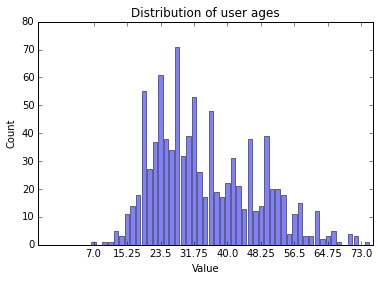

In [8]:
users.show().histogram(users['age'], title='Distribution of user ages')

Or we could find out about the gender distribution of the users.

In [9]:
print users.groupby('gender', COUNT)

+--------+-------+
| gender | count |
+--------+-------+
|   M    |  670  |
|   F    |  273  |
+--------+-------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


Now we will read and take a peek at the other tables: the movies and ratings.

In [10]:
movies = XFrame.read_csv('movie-data/ml-100k/u.item', delimiter='|')
print movies

+----------+--------------------------------+--------------+
| movie_id |              name              | release_date |
+----------+--------------------------------+--------------+
|    1     |        Toy Story (1995)        | 01-Jan-1995  |
|    2     |        GoldenEye (1995)        | 01-Jan-1995  |
|    3     |       Four Rooms (1995)        | 01-Jan-1995  |
|    4     |       Get Shorty (1995)        | 01-Jan-1995  |
|    5     |         Copycat (1995)         | 01-Jan-1995  |
|    6     | Shanghai Triad (Yao a yao  ... | 01-Jan-1995  |
|    7     |     Twelve Monkeys (1995)      | 01-Jan-1995  |
|    8     |          Babe (1995)           | 01-Jan-1995  |
|    9     |    Dead Man Walking (1995)     | 01-Jan-1995  |
|    10    |       Richard III (1995)       | 22-Jan-1996  |
+----------+--------------------------------+--------------+
+--------------------+--------------------------------+---------+
| video_release_date |            imdb_url            | unknown |
+-------------

We are going to separate out the movie names, for later use.

In [11]:
movie_names = movies[['movie_id', 'name']]
movie_names.movie_id = movie_names.movie_id.astype(int)

The ratings are tab delimited.

In [12]:
ratings = XFrame.read_csv('movie-data/ml-100k/u.data', delimiter='\t')
print ratings

+---------+---------+--------+-----------+
| user_id | item_id | rating | timestamp |
+---------+---------+--------+-----------+
|   196   |   242   |   3    | 881250949 |
|   186   |   302   |   3    | 891717742 |
|    22   |   377   |   1    | 878887116 |
|   244   |    51   |   2    | 880606923 |
|   166   |   346   |   1    | 886397596 |
|   298   |   474   |   4    | 884182806 |
|   115   |   265   |   2    | 881171488 |
|   253   |   465   |   5    | 891628467 |
|   305   |   451   |   3    | 886324817 |
|    6    |    86   |   3    | 883603013 |
+---------+---------+--------+-----------+
[? rows x 4 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


### Act

Using the ratings, we can build a model to predict user scores.

In [13]:
model = recommender.create(ratings, 'user_id', 'item_id', 'rating')
print model

user_col: user_id
item_col: item_id
rating_col: rating


Using the model, we can predict the rating a given user would give a movie.

In [14]:
user = 789
movie = 123
print model.predict(user, movie)

3.29971613192


In [15]:
x = XFrame({'id': [1, 2, 3], 'val': ['a', 'b', 'c']})
y = XArray([1])
print x.filterby(y, 'id', exclude=True)

+----+-----+
| id | val |
+----+-----+
| 2  |  b  |
| 3  |  c  |
+----+-----+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


We can also use the model to predict how that user would rate all the movies, and pick the ones that have the highest ratings.

In [16]:
recommendations = model.recommend_top_k(user)
print recommendations

+---------+---------+---------------+
| user_id | item_id |     rating    |
+---------+---------+---------------+
|   789   |   921   | 5.57143847144 |
|   789   |   525   | 5.44679163436 |
|   789   |   187   | 5.33335791014 |
|   789   |    39   | 5.32368995771 |
|   789   |    46   | 5.29513275928 |
|   789   |   195   | 5.26166235073 |
|   789   |   200   | 5.23285501395 |
|   789   |   250   | 5.21008293404 |
|   789   |    24   | 5.19726518349 |
|   789   |   207   |  5.1820184308 |
+---------+---------+---------------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


What movies there these?

In [17]:
print recommendations.join(movie_names, on={'item_id': 'movie_id'}) \
                                                       .sort('rating', ascending=False)

+---------+---------+---------------+--------------------------------+
| user_id | item_id |     rating    |              name              |
+---------+---------+---------------+--------------------------------+
|   789   |   921   | 5.57143847144 |  Farewell My Concubine (1993)  |
|   789   |   525   | 5.44679163436 |     Big Sleep, The (1946)      |
|   789   |   187   | 5.33335791014 | Godfather: Part II, The (1974) |
|   789   |    39   | 5.32368995771 |      Strange Days (1995)       |
|   789   |    46   | 5.29513275928 |         Exotica (1994)         |
|   789   |   195   | 5.26166235073 |     Terminator, The (1984)     |
|   789   |   200   | 5.23285501395 |      Shining, The (1980)       |
|   789   |   250   | 5.21008293404 |   Fifth Element, The (1997)    |
|   789   |    24   | 5.19726518349 |   Rumble in the Bronx (1995)   |
|   789   |   207   |  5.1820184308 |   Cyrano de Bergerac (1990)    |
+---------+---------+---------------+--------------------------------+
[? row

What were some of the movies that this user rated most highly?

In [18]:
print ratings.filterby(789, 'user_id').join(movie_names, on={'item_id': 'movie_id'})   \
                    .sort('rating', ascending=False)

+---------+---------+--------+-----------+
| user_id | item_id | rating | timestamp |
+---------+---------+--------+-----------+
|   789   |   100   |   5    | 880332089 |
|   789   |   741   |   5    | 880332148 |
|   789   |   127   |   5    | 880332039 |
|   789   |   276   |   5    | 880332063 |
|   789   |    50   |   5    | 880332114 |
|   789   |   129   |   5    | 880332063 |
|   789   |   150   |   5    | 880332333 |
|   789   |    9    |   5    | 880332114 |
|   789   |   475   |   5    | 880332063 |
|   789   |    93   |   4    | 880332063 |
+---------+---------+--------+-----------+
+--------------------------------+
|              name              |
+--------------------------------+
|          Fargo (1996)          |
|    Last Supper, The (1995)     |
|     Godfather, The (1972)      |
|    Leaving Las Vegas (1995)    |
|        Star Wars (1977)        |
|          Bound (1996)          |
|        Swingers (1996)         |
|    Dead Man Walking (1995)     |
|      Trains

Save the model for later use.

In [19]:
model.save('models/recommender-model')

## What is xFrames ?

* A python library for handling tabular data
* A better was to program in pySpark
* A tool for exploring and manipulating large data sets
* An abstraction layer that ties together several underlying technologies

-----

* A high level language for tabular data, embedded in python
* Implemented by interpretation
* Uses a virtual machine based on pySpark

## xFrames Key Goals

* Remove the need to learn new programming styles, such as map/reduce and RDDs
* Anyone familiar with python can work with Big Data at scale
* Simplify and speed development when working with tabular data
* Work seamlessly with pySpark and other python-based technologies such as pandas and the DAL DataFramePlus
* Make it easy to get started by using a container
* Lightweight: pure python with minimal dependencies; easy to install

# XFrame Fundamentals

The key objects are XArray and XFrame, representing vectors and matrices.

## XArray

* An XArray is a vector of values of a uniform type
* Can be any type that is serializable by python: int, float, list, dict
* An XArray is immutable
* Each XArray instance contains a single spark RDD, which holds the actual data

In [20]:
print XArray([1, 2, 3])

[1, 2, 3]


In [21]:
print XArray(['a', 'b', 'c'])
print XArray([[1, 2], [1, 3], [5, 6]])
print XArray([{'user': 'charlie', 'score': 92}, {'user': 'joe', 'score': 95}])
print XArray(range(10))

['a', 'b', 'c']
[[1, 2], [1, 3], [5, 6]]
[{'score': 92, 'user': 'charlie'}, {'score': 95, 'user': 'joe'}]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


## XFrame

* A table of fixed width, where each column has a name and a type
* The XFrame columns are immutable, but columns can be added or deleted from an XFrame 
* Each XFrame instance contains a single spark RDD, which holds the actual data

In [22]:
print XFrame({'id': [1, 2, 3], 'name': ['charlie', 'joe', 'jason'], 'scores': [[90, 80], [80], [95, 99]]})

+----+---------+----------+
| id |   name  |  scores  |
+----+---------+----------+
| 1  | charlie | [90, 80] |
| 2  |   joe   |   [80]   |
| 3  |  jason  | [95, 99] |
+----+---------+----------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


## Reading Data

* Data can be read from a file to create an XFrame
* The file can be stored on S3, hdfs, or locally.
* The file can be text (delimited), parquet, hive, various hdfs file types, or spark binary storage format
* XFrame tries to guess storage format from the filename extension
* XFrame takes column names and types from metadata or column headings if available; guesses column types from the firs portion of the data
* Application can optionally supply file type, column names, or column types
* Factory methods such as XFrame.read_csv allow greater control over delimiters, quoting, and other parameters


In [23]:
print XFrame('example.csv')

+---------+---------+-------+
| user_id |   name  | score |
+---------+---------+-------+
|    1    | charlie |   87  |
|    1    | charlie |   92  |
|    2    |   joe   |   90  |
|    3    |  jason  |   95  |
+---------+---------+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


## Loading Data

Loading data refers to bringing data that is already in python into an XFrame
* Data can be a dictionary, an array, a spark DataFrame, a spark RDD, a pandas DataFrame, an XArray or an XFrame
* There are similar operations for XArray
* Column names and types are assigned from the data or guessed if necessary

In [24]:
xf = XFrame([1, 2, 3])
print xf
print XFrame(xf)
xa = XArray([3, 1, 4, 1, 5])
print XFrame(xa)

+----+
| X0 |
+----+
| 1  |
| 2  |
| 3  |
+----+
[? rows x 1 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.
+----+
| X0 |
+----+
| 1  |
| 2  |
| 3  |
+----+
[? rows x 1 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.
+----+
| X0 |
+----+
| 3  |
| 1  |
| 4  |
| 1  |
| 5  |
+----+
[? rows x 1 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


## Saving Data

An XFrame can be saved as binary, csv, or parquet
* Binary is actually a hadoop SequenceFile, and can be read back efficiently
* The order may not be preserved when reading a file saved in binary

In [25]:
xf = XFrame('example.csv')
xf.save('data/some-data')
xf.save('data/some-csv-data.csv')

In [26]:
print XFrame('data/some-data')

+---------+---------+-------+
| user_id |   name  | score |
+---------+---------+-------+
|    2    |   joe   |   90  |
|    3    |  jason  |   95  |
|    1    | charlie |   87  |
|    1    | charlie |   92  |
+---------+---------+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [27]:
print XFrame('data/some-csv-data.csv')

+---------+---------+-------+
| user_id |   name  | score |
+---------+---------+-------+
|    1    | charlie |   87  |
|    1    | charlie |   92  |
|    2    |   joe   |   90  |
|    3    |  jason  |   95  |
+---------+---------+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


## Exporting Data

An XFrame can be used by pandas or spark.

In [30]:
print xf.to_pandas_dataframe()

   user_id     name  score
0        1  charlie     87
1        1  charlie     92
2        2      joe     90
3        3    jason     95


In [31]:
print xf.to_spark_dataframe().collect()

[Row(user_id=1, name=u'charlie', score=92), Row(user_id=3, name=u'jason', score=95), Row(user_id=1, name=u'charlie', score=87), Row(user_id=2, name=u'joe', score=90)]


In [32]:
print xf.to_rdd().collect()

[(1, 'charlie', 87), (1, 'charlie', 92), (2, 'joe', 90), (3, 'jason', 95)]


## Using Spark SQL

You can use the XFrame operations to do equivalent operations, but you might want to use spark SQL operations instead.  This is easy to do; the result is returned as an XFrame.  Any sql statement in spark SQL is accepted.

In [33]:
print xf.sql('select * from xf where score >= 90', 'xf')

+---------+---------+-------+
| user_id |   name  | score |
+---------+---------+-------+
|    2    |   joe   |   90  |
|    1    | charlie |   92  |
|    3    |  jason  |   95  |
+---------+---------+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


## Iteration

It is possible to iterate over the rows in an XArray, although it is slow, because the data must be brought in to the master

In [34]:
xf = XFrame({'id': range(0, 10), 'score': range(10, 20)})
for row in xf: print row

{'score': 10, 'id': 0}
{'score': 11, 'id': 1}
{'score': 12, 'id': 2}
{'score': 13, 'id': 3}
{'score': 14, 'id': 4}
{'score': 15, 'id': 5}
{'score': 16, 'id': 6}
{'score': 17, 'id': 7}
{'score': 18, 'id': 8}
{'score': 19, 'id': 9}


In [35]:
print xf[3]

{'score': 13, 'id': 3}


In [36]:
print xf[3:5]

+----+-------+
| id | score |
+----+-------+
| 3  |   13  |
| 4  |   14  |
+----+-------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [37]:
print xf[:4]

+----+-------+
| id | score |
+----+-------+
| 0  |   10  |
| 1  |   11  |
| 2  |   12  |
| 3  |   13  |
+----+-------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [38]:
print xf['id'][3]

3


## Table Information

It is easy to get information about a table, and print some of the rows.
* Get colum names and types
* Get table length (forces evaluation)
* Print first rows of the table

In [39]:
print xf.column_names()
print xf.column_types()

['id', 'score']
[<type 'int'>, <type 'int'>]


In [40]:
print len(xf)
print
print xf

10

+----+-------+
| id | score |
+----+-------+
| 0  |   10  |
| 1  |   11  |
| 2  |   12  |
| 3  |   13  |
| 4  |   14  |
| 5  |   15  |
| 6  |   16  |
| 7  |   17  |
| 8  |   18  |
| 9  |   19  |
+----+-------+
[10 rows x 2 columns]



In [41]:
xf.print_rows(num_rows=5)

+-----+-------+
|  id | score |
+-----+-------+
|  0  |   10  |
|  1  |   11  |
|  2  |   12  |
|  3  |   13  |
|  4  |   14  |
| ... |  ...  |
+-----+-------+
[10 rows x 2 columns]



## Column Arithmetic

Selecting a column from an XFrame gives an XArray.  Vector and scalar arithmetic is defined on XArrays.

In [42]:
print xf['id']
print xf.id

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [43]:
id = xf['id']
print id * 2
print id + 1
print id * id
print (3 * id)  **2 - id
print id.mean()

[0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 8, 34, 78, 140, 220, 318, 434, 568, 720]
4.5


Usually, columns are extracted from tables and assigned back into the table after performing some operation.

In [44]:
xf.score = 2*xf.score
print xf

+----+-------+
| id | score |
+----+-------+
| 0  |   20  |
| 1  |   22  |
| 2  |   24  |
| 3  |   26  |
| 4  |   28  |
| 5  |   30  |
| 6  |   32  |
| 7  |   34  |
| 8  |   36  |
| 9  |   38  |
+----+-------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


## Column and Row Filtering

Column filtering makes a table from a subset of the columns in another table.

In [45]:
xf = XFrame({'id': range(0, 10), 'score': range(10, 20), 'charge': range(100,110)})
xf.print_rows(num_rows=3)

+--------+----+-------+
| charge | id | score |
+--------+----+-------+
|  100   | 0  |   10  |
|  101   | 1  |   11  |
|  102   | 2  |   12  |
+--------+----+-------+
[10 rows x 3 columns]



In [46]:
print xf[['id', 'charge']]

+----+--------+
| id | charge |
+----+--------+
| 0  |  100   |
| 1  |  101   |
| 2  |  102   |
| 3  |  103   |
| 4  |  104   |
| 5  |  105   |
| 6  |  106   |
| 7  |  107   |
| 8  |  108   |
| 9  |  109   |
+----+--------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


The XFrame can be modified by removing a column.

In [47]:
xf.remove_column('charge')
xf.print_rows(num_rows=3)

+----+-------+
| id | score |
+----+-------+
| 0  |   10  |
| 1  |   11  |
| 2  |   12  |
+----+-------+
[10 rows x 2 columns]



## Row Filters

There are several ways to filter rows from an XArray.

The table can be indexed by a boolean array, produced through column arithmetic.

In [48]:
xf = XFrame({'id': range(0, 10), 'score': range(10, 20), 'charge': range(100,110)})
print xf

+--------+----+-------+
| charge | id | score |
+--------+----+-------+
|  100   | 0  |   10  |
|  101   | 1  |   11  |
|  102   | 2  |   12  |
|  103   | 3  |   13  |
|  104   | 4  |   14  |
|  105   | 5  |   15  |
|  106   | 6  |   16  |
|  107   | 7  |   17  |
|  108   | 8  |   18  |
|  109   | 9  |   19  |
+--------+----+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [49]:
print xf[xf['id'] > 4]

+--------+----+-------+
| charge | id | score |
+--------+----+-------+
|  105   | 5  |   15  |
|  106   | 6  |   16  |
|  107   | 7  |   17  |
|  108   | 8  |   18  |
|  109   | 9  |   19  |
+--------+----+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [50]:
print xf[(xf.id > 4) & (xf.score <= 17)]

+--------+----+-------+
| charge | id | score |
+--------+----+-------+
|  105   | 5  |   15  |
|  106   | 6  |   16  |
|  107   | 7  |   17  |
+--------+----+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


Alternatively, rows can be filtered by a set of values in a given column.

This works, even for very large numbers of matching values, given in an XArray.

The filter can exclude as well as match.

In [51]:
print xf.filterby(3, 'id')
print xf.filterby([2, 4, 5], 'id')

+--------+----+-------+
| charge | id | score |
+--------+----+-------+
|  103   | 3  |   13  |
+--------+----+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.
+--------+----+-------+
| charge | id | score |
+--------+----+-------+
|  104   | 4  |   14  |
|  105   | 5  |   15  |
|  102   | 2  |   12  |
+--------+----+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [52]:
xa = XArray([2, 4, 6, 7])
print xf.filterby(xa, 'id')

+--------+----+-------+
| charge | id | score |
+--------+----+-------+
|  104   | 4  |   14  |
|  102   | 2  |   12  |
|  106   | 6  |   16  |
|  107   | 7  |   17  |
+--------+----+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [53]:
print xf.filterby(xa, 'id', exclude=True)

+--------+----+-------+
| charge | id | score |
+--------+----+-------+
|  105   | 5  |   15  |
|  108   | 8  |   18  |
|  109   | 9  |   19  |
|  103   | 3  |   13  |
|  100   | 0  |   10  |
|  101   | 1  |   11  |
+--------+----+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


Finally, the beginning or ed of the XFrame can be extracted.

In [54]:
print xf.head(2)
print xf.tail(2)

+--------+----+-------+
| charge | id | score |
+--------+----+-------+
|  100   | 0  |   10  |
|  101   | 1  |   11  |
+--------+----+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.
+--------+----+-------+
| charge | id | score |
+--------+----+-------+
|  108   | 8  |   18  |
|  109   | 9  |   19  |
+--------+----+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


## XArray Transformation

A transformation function can be applied to a column or to the table row.  

In either case, the function returns a single value, which is collected into an XArray.  This is usually stored in a new column, or used to overwrite an existing column.

When transforming a row, the function receives the row as a dictionary of column name/value pairs.

In [55]:
xf = XFrame({'id': range(0, 10), 'score': range(10, 20), 'charge': range(100,110)})

In [56]:
from math import sqrt
xf.sqrt = xf.score.apply(lambda x: sqrt(x))
print xf

+--------+----+-------+---------------+
| charge | id | score |      sqrt     |
+--------+----+-------+---------------+
|  100   | 0  |   10  | 3.16227766017 |
|  101   | 1  |   11  | 3.31662479036 |
|  102   | 2  |   12  | 3.46410161514 |
|  103   | 3  |   13  | 3.60555127546 |
|  104   | 4  |   14  | 3.74165738677 |
|  105   | 5  |   15  | 3.87298334621 |
|  106   | 6  |   16  |      4.0      |
|  107   | 7  |   17  | 4.12310562562 |
|  108   | 8  |   18  | 4.24264068712 |
|  109   | 9  |   19  | 4.35889894354 |
+--------+----+-------+---------------+
[? rows x 4 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [57]:
print xf.apply(lambda row: row['charge'] - row['id'])

[100, 100, 100, 100, 100, 100, 100, 100, 100, 100]


## Other Useful Transformations -- Pack and Stack

Packing is transforming multiple columns into a single column by combining them into a dictionary or list.

Unpacking transforms a list or dictionary in a column into multiple columns.

Stacking takes values in a list or dictionary and puts them in multiple rows.

Unstacking takes multiple rows into a dictiary or list in one row.

These are rarely used but when they are needed they are vital.  They are useful when operating on aggregated data produced by groupby.  For instance, these were used in detecting fuzzy duplicates and hospital readmissions.

## Missing Values

In [58]:
xf = XFrame({'id': [1, 2, 3], 'name': ['charlie', 'joe', 'jason'], 'scores': [[90, 80], None, [95, 99]]})
print xf

+----+---------+----------+
| id |   name  |  scores  |
+----+---------+----------+
| 1  | charlie | [90, 80] |
| 2  |   joe   |   None   |
| 3  |  jason  | [95, 99] |
+----+---------+----------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [59]:
print xf.dropna()

+----+---------+----------+
| id |   name  |  scores  |
+----+---------+----------+
| 1  | charlie | [90, 80] |
| 3  |  jason  | [95, 99] |
+----+---------+----------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [60]:
print xf.fillna('scores', [])

+----+---------+----------+
| id |   name  |  scores  |
+----+---------+----------+
| 1  | charlie | [90, 80] |
| 2  |   joe   |    []    |
| 3  |  jason  | [95, 99] |
+----+---------+----------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [61]:
ok, missing = xf.dropna_split()
print ok
print missing

+----+---------+----------+
| id |   name  |  scores  |
+----+---------+----------+
| 1  | charlie | [90, 80] |
| 3  |  jason  | [95, 99] |
+----+---------+----------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.
+----+------+--------+
| id | name | scores |
+----+------+--------+
| 2  | joe  |  None  |
+----+------+--------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


## Other Transformations

Add a row number to an XArray, optionally giving the column name.

In [62]:
xf = XFrame({'name': ['charlie', 'joe', 'jason'], 'scores': [[90, 80], None, [95, 99]]})
print xf

+---------+----------+
|   name  |  scores  |
+---------+----------+
| charlie | [90, 80] |
|   joe   |   None   |
|  jason  | [95, 99] |
+---------+----------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [63]:
print xf.add_row_number()

+----+---------+----------+
| id |   name  |  scores  |
+----+---------+----------+
| 0  | charlie | [90, 80] |
| 1  |   joe   |   None   |
| 2  |  jason  | [95, 99] |
+----+---------+----------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [64]:
xf1 = XFrame({'name': ['charlie', 'joe'], 'scores': [[90, 80], None]})
xf2 = XFrame({'name': ['jason'], 'scores': [[95, 99]]})
print xf1
print xf2

+---------+----------+
|   name  |  scores  |
+---------+----------+
| charlie | [90, 80] |
|   joe   |   None   |
+---------+----------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.
+-------+----------+
|  name |  scores  |
+-------+----------+
| jason | [95, 99] |
+-------+----------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [65]:
print xf1.append(xf2)

+---------+----------+
|   name  |  scores  |
+---------+----------+
| charlie | [90, 80] |
|   joe   |   None   |
|  jason  | [95, 99] |
+---------+----------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


## Sort and Unique

In [66]:
xf = XFrame({'id': range(10)})
xf.val = xf.id/2
print xf

+----+-----+
| id | val |
+----+-----+
| 0  |  0  |
| 1  |  0  |
| 2  |  1  |
| 3  |  1  |
| 4  |  2  |
| 5  |  2  |
| 6  |  3  |
| 7  |  3  |
| 8  |  4  |
| 9  |  4  |
+----+-----+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [67]:
print xf.sort('val')
print xf.sort('val', ascending=False)
print xf.sort(['val', 'id'], ascending=False)

+----+-----+
| id | val |
+----+-----+
| 0  |  0  |
| 1  |  0  |
| 2  |  1  |
| 3  |  1  |
| 4  |  2  |
| 5  |  2  |
| 6  |  3  |
| 7  |  3  |
| 8  |  4  |
| 9  |  4  |
+----+-----+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.
+----+-----+
| id | val |
+----+-----+
| 8  |  4  |
| 9  |  4  |
| 6  |  3  |
| 7  |  3  |
| 4  |  2  |
| 5  |  2  |
| 2  |  1  |
| 3  |  1  |
| 0  |  0  |
| 1  |  0  |
+----+-----+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.
+----+-----+
| id | val |
+----+-----+
| 9  |  4  |
| 8  |  4  |
| 7  |  3  |
| 6  |  3  |
| 5  |  2  |
| 4  |  2  |
| 3  |  1  |
| 2  |  1  |
| 1  |  0  |
| 0  |  0  |
+----+-----+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


Sometimes all we need is a list of the largest (or smallest) values in a column.

In [68]:
print xf.topk('id', k=3)
print xf.topk('id', reverse=True, k=3)

+----+-----+
| id | val |
+----+-----+
| 9  |  4  |
| 8  |  4  |
| 7  |  3  |
+----+-----+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.
+----+-----+
| id | val |
+----+-----+
| 0  |  0  |
| 1  |  0  |
| 2  |  1  |
+----+-----+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


To get an XArray of the unique values in a given column, use 'unique'.

In [69]:
print xf.val.unique()

[0, 4, 1, 2, 3]


## Aggregation

Building on the unique example above, we might want to find how many rows were associated with each unique value.  Furthermore, we might need to collect, or average, or do some other operation on all the elements in the group of rows associated with each unique value.

In [70]:
xf = XFrame({'id': range(10)})
xf.val = xf.id/2
print xf

+----+-----+
| id | val |
+----+-----+
| 0  |  0  |
| 1  |  0  |
| 2  |  1  |
| 3  |  1  |
| 4  |  2  |
| 5  |  2  |
| 6  |  3  |
| 7  |  3  |
| 8  |  4  |
| 9  |  4  |
+----+-----+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [71]:
print xf.groupby('val', COUNT)

+-----+-------+
| val | count |
+-----+-------+
|  3  |   2   |
|  4  |   2   |
|  0  |   2   |
|  1  |   2   |
|  2  |   2   |
+-----+-------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


You can name the aggregate column.  If you don't, a reasonable name is supplied, as above.

In [72]:
print xf.groupby('val', {'number': COUNT})

+-----+--------+
| val | number |
+-----+--------+
|  3  |   2    |
|  4  |   2    |
|  0  |   2    |
|  1  |   2    |
|  2  |   2    |
+-----+--------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


You can create multiple aggregates in one call to groupby.  Some aggregate functions have column name arguments.

In [74]:
print xf.groupby('val', {'number': COUNT, 'avg': MEAN('id')})

+-----+-----+--------+
| val | avg | number |
+-----+-----+--------+
|  3  | 6.5 |   2    |
|  4  | 8.5 |   2    |
|  0  | 0.5 |   2    |
|  1  | 2.5 |   2    |
|  2  | 4.5 |   2    |
+-----+-----+--------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


Concatenation is very useful, because you can  do further processing on the new value.  Hospital readmissions starts this way, grouping on the readmission criteria and concatenating the discharge and admission dates.  The concatenated field is often expanded into multiple rows after processing using 'stack'.

In [75]:
print xf.groupby('val', {'number': COUNT, 'ids': CONCAT('id'), 'avg': MEAN('id')})

+-----+-----+--------+--------+
| val | avg | number |  ids   |
+-----+-----+--------+--------+
|  3  | 6.5 |   2    | [6, 7] |
|  4  | 8.5 |   2    | [8, 9] |
|  0  | 0.5 |   2    | [0, 1] |
|  1  | 2.5 |   2    | [2, 3] |
|  2  | 4.5 |   2    | [4, 5] |
+-----+-----+--------+--------+
[? rows x 4 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


## Joining Tables

Join builds on groupby by combining rows of different tables that share a common value.

In [76]:
users = XFrame({'user_id':  [1, 2, 3], 'name': ['charlie', 'joe', 'jason']})
scores = XFrame({'user_id': [1, 1, 3], 'score': [90, 80, 95]})
print users
print scores

+---------+---------+
|   name  | user_id |
+---------+---------+
| charlie |    1    |
|   joe   |    2    |
|  jason  |    3    |
+---------+---------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.
+-------+---------+
| score | user_id |
+-------+---------+
|   90  |    1    |
|   80  |    1    |
|   95  |    3    |
+-------+---------+
[? rows x 2 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


In [77]:
print users.join(scores)

+---------+---------+-------+
|   name  | user_id | score |
+---------+---------+-------+
|  jason  |    3    |   95  |
| charlie |    1    |   90  |
| charlie |    1    |   80  |
+---------+---------+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


If the column names in the tables differ, then they can be supplied explicitly.  Otherwise, the join takes place on all common columns.

In [78]:
users = XFrame({'user':  [1, 2, 3], 'name': ['charlie', 'joe', 'jason']})
scores = XFrame({'user_id': [1, 1, 3], 'score': [90, 80, 95]})
print users.join(scores, on={'user': 'user_id'})

+---------+------+-------+
|   name  | user | score |
+---------+------+-------+
|  jason  |  3   |   95  |
| charlie |  1   |   90  |
| charlie |  1   |   80  |
+---------+------+-------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


Other join options:
* Multiple column join keys: users.join(socres, [user_id', 'semester'])
* Other join types: users.join(scores, how='right')

## Column Summary Information -- Sketch

A *Sketch* contains summary information about a column.  This includes statistics like the number of items, the min and the max.
For numerical columns, the sketch also include statistics such as the sum, mean and standard deviation.

The sketch also includes information that is computed approximately.  This includes quantile information and occurrence counts for the most frequently occurring items.  These approximations are created in bounded space efficiently on a distributed cluster.

In [79]:
xa = XArray([2, 2, 3, 4, 4, 4, 5])

In [80]:
ss = xa.sketch_summary()
print ss.size()
print ss.min(),  ss.max()
print ss.std()

7
2.0 5.0
1.04978131834


In [81]:
print ss.quantile(0.5)

3.99969482422


In [82]:
print ss.frequent_items()
print ss.frequency_count(2)

{2: 2, 3: 1, 4: 3, 5: 1}
2


## Plotting

In general, plotting is best left to the application.  Matplotlib provides a wealth of plot types and options, and the data has to be brought into python on the master to plot anyway.  

With this in mind, XFrames plotting is limited to plots that help to understand the general characteristics of the data.  This includes plotting a histogram of values in a numerical column, and a frequent-values plot for categorical data.

In [83]:
xf = XFrame('scores.csv')

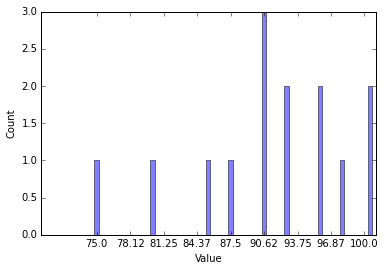

In [85]:
xf.show().histogram(xf['score'])

There are many plotting and labeling options that you can use to customize the plot.  Here we change the number of bins and label the y axis.

step 1


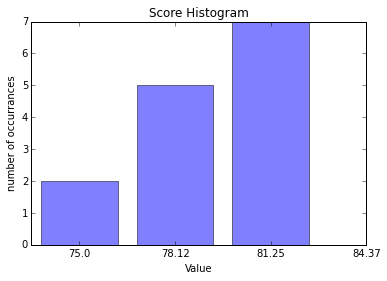

In [89]:
xf.show().histogram(xf['score'], bins=3, ylabel='number of occurrances', title='Score Histogram')

The next plot illustrates showing the most frequent items in a column.

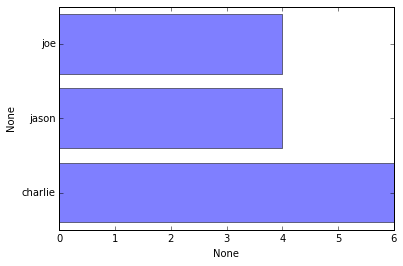

In [93]:
xf.show().frequent_values('name')

## MLlib

MLlib is a machine learning library for spark.  It does not aim to be comprehensive, but does include a number of modeling algorithms that are designed to run well in a distributed computing cluster.  

For a more extensive machine learning library you can create a pandas DataFrame or an xPatterns DataFramePlus, and use machine learning algorithms from SciKitLearn, or from the xPatterns machine learning library.  You might need to take a sample of the data, using XFrame.sample.

To use the spark MLlib functions you could use XFrame.to_spark_dataframe and call MLlib directly.  The xFrames library includes convenience functions that allow you to conveniently operate on XFrame objects directly.  


In [94]:
ratings = XFrame('models/recommender-model/ratings')
ratings.print_rows(num_rows=3)

+---------+---------+--------+-----------+
| user_id | item_id | rating | timestamp |
+---------+---------+--------+-----------+
|    42   |   523   |   5    | 881107375 |
|   286   |   741   |   4    | 876521887 |
|   436   |   1058  |   4    | 887770547 |
+---------+---------+--------+-----------+
[100000 rows x 4 columns]



We can create a model from the existing ratings by giving a XFrame, and the column names containing the user, item, and rating data.

In [95]:
model = recommender.create(ratings, 'user_id', 'item_id', 'rating')

Using a trained model, we can then predict how a given user would rate movies.  The recommend_top_k function finds the highest predictions for a given user among the items that user has not already rated.

In [96]:
print model.recommend_top_k(42)

+---------+---------+---------------+
| user_id | item_id |     rating    |
+---------+---------+---------------+
|    42   |   393   | 5.68227442553 |
|    42   |   166   | 5.66388908203 |
|    42   |   520   | 5.49942144465 |
|    42   |    22   | 5.43843581225 |
|    42   |   313   | 5.42042010567 |
|    42   |   165   |  5.2414310761 |
|    42   |   609   | 5.18912790745 |
|    42   |   139   | 5.09336557996 |
|    42   |   482   | 5.04372048271 |
|    42   |   199   |  5.0372788594 |
+---------+---------+---------------+
[? rows x 3 columns]
Note: Only the head of the XFrame is printed. This XFrame is lazily 
evaluated.  You can use len(xf) to force materialization.


Normally you need to store a model and to read it back later.

In [97]:
model.save('models/my_model')

### Other MLlib Models

MLlib includes models for classification and regression.  These are included in xFrames, but the implementation is incomplete because the python interface to this part of MLlib is incomplete. For instance, the current version of the classifier and regression model objects are missing load and save methods.

## Getting Started

The easiest way to get started is to install a Docker container, which contains a spark installation running in local mode.

Check out the xFrame project from gitlab: 

    git clone http://github.com/Atigeo/xpatterns-xframe
    cd xframe/docker
    ./build-xframes-docker
    ./run-xframes-docker

Then browse to:

    http://localhost:7777/tree

You can navigate to intro/Presentation.ipynb to see this presentation notebook.

Note: this has been tested on Ubunto and Mac, but not on Windows.

## How To Install xFrames

xFrames can be used in two modes: local and cluster.  In local mode, your program, the spark master, and the spark workers all run on your computer.  In this mode you can process data sets of modest size in reasonable time.  It is easiest to get started with local mode, because you can install everything you need.


xFrames itself is simply a python library that be installed anywhere on the PYTHONAPTH.  If you already have IPython Notebook, spark, pandas, matplotlab, and the other dependencies installed and working, this might be the best option.  For most people it is easiest to use a Docker container, which supplies everything in one package.

# Under The Hood

## xFrame Design Principles

The most important design principle was to hide the spark implementation behind an interface.  The data scientist should not have to understand RDDs and how they work: everything that they need should be explainable in terms of arrays and frames.

The next principle was to delegate the data manipulation itself to spark.  All XArray and XFrame operations result in calls to spark operations: the data never comes back to the master or to the application except as requested (to print or to return to the application).  This ensures that any improvements in spark's speed or memory performance will flow directly to xFrames.

A related considerations was to make sure that xFrames does not subvert the spark laze evaluator.  For the most part, spark avoids performing any real work until the answer is actually required.  However, there are some operations (such as zipWithIndex) that force the lazy evaluator into action.  xFrames does everything it can to avoid invoking these operations.  When it must, xFrames caches the results so that subsequent operations reuse the intermediate results.

Another principle was to build on python's operator overloading facility to make the syntax for vector arithmetic and column and row filtering simple and compact.  This approach was proven out by pandas, and gives xFrames the same flavor.

The last principle was to provide high level operations that are tuned to the needs of the data scientist.  This includes explicit support for dealing with missing data, flexible support for grouping, joining, and filtering, and support for data reshaping operations such as pack/unpack/stack/unstack.

## xFrames Challenges

xFrames development is at an early stage.  It has been used internally for several projects and has been extensively unit tested, but it still has a number of limitations.

The goal with xFrames is to achieve the same or better performance as hand-crafted spark code.  Currently the XFrame methods takes the simplest and most straightforward strategy to implement each of its operations.  As time goes on we can discover where performance could be improved by better strategies, and supply them in the library.  In this way, we insulate the data scientist from having to become expert in spark optimization and have a place to encode our spark expertise for all to use.

Spark's lazy evaluation improves the interactive experience and the overall execution time, but it does so at the expense of usable error messages.  The problem is that many things that can go wrong in a computation do not surface until the very last step, where the answer is being evaluated (often in a save, count, or collect operation).  The error was actually made long before this point, and the spark error output is often of little help in identifying what went wrong.

xFrames addresses this by doing extensive checking before calling the spark operations.  It keeps track of column name and type as the operations are being interpreted (not in a lazy way) so that type errors are reported as they occur.  That does not completely solve the problem, so we need to find a way to analyze the kinds of failures people see in practice and relate them to the real source of the error.

Finally, there are a number of spark API functions that are not used by xFrames.  We need to understand why these were included in spark: what they are for and when they would be appropriate to use.  In some cases, they are provided for performance improvement.  In these cases, the xFrames library needs to detect when it is in a situation appropriate to these specialized operations, and to make use of them.  If there are operations that are there because they are essential to some use case, then we need to evaluate whether xFrames needs a corresponding API.


## Possible Improvements

### Core Improvements

* Better caching strategy
  * If there is too little caching data is recomputed
  * IOf there is too much caching data written to disk needlessly
* Better algorithms
  * Make better use if paritition-aware methods such as mapPartition
  * Use different strategies fior different cases (for instance, implement filterby with filter for small sets, join for larger ones)
  * Need better zip that does not require aligned partitions, but that does not do shuffle if they are aligned
* Better partitioning strategy
  * Maintain enough partitions to make use of cluster nodes/cores
  * Balance with shuffle overhead

### Machine Learning Improvements

* MLlib (pySpark) is incomplete, inconsistent, and buggy (not ready for serious use)
  * Model save/load is missing for most models
  * Limited selection of algorithms
* MLlib is being phased out in favor of ML
* Can we wrap in xframes so the differences can be hidden?

## Implementation Details

### Storge Format

For an XFrame, there are two ways that the data could have been stored: each row of the XFrame could be stored in an RDD row, or else each column could be stored separately.  Each makes sense: each choice makes some operations faster and others slower.

Columnar storage makes vector arithmetic, column operations, and groupby efficient, but sort, filter, and join inefficient.

Row storage makes sort, filter, and join efficient and vector arithmetic inefficient.  

Either choice required RDD functions in the zip family (zip, zipWithIndex, etc).  These operations are problematic for the following reasons:
  * ZipWithIndex does not work well with lazy evluation: it evaluates the RDD
  * Operands of zip must have the same number of partitions, and the same number of elements in each partition.  There is no way to determine, at runtime, of these conditions are met.
  * Before spark 1.3, pySpark zip operations were buggy
  
For simplicity, we decided to use row order for storing XFrames in RDDs.  It should be noted that internally the DataFrame (a subclass of RDD) stores data in columnar order, so it might be possible to use that to switch back and forth, depending on the nature of the operations being performed.

Each XArray and XFrame instance stores exactly one RDD.  All data is in the RDD.  In addition, type information as well as column name information (for XFrames) is stored outside the RDD.  

When an XArray or XFrame is stored, the additional information is also stored.  The load functions use this to restore the additional data.


### Operations

Operator overloading is done using pythons *special function names*.  For instance, `a + b` is implemented as as `a.__add__(b)`, a method of class a.  This is used for the unary and binary scalar and vector arithmetic functions on XArray.

In addition, the square bracket operation is implemented by `__getitem__` and `__setitem__`.  The XFrame method tests the type of the operand (at runtime) and implements either row selection (if the operand is an XArray) or column selection (if the operand is a string or a list of strings).  

Many other XArray and XFrame make use of operand type overloading, performing different operations if their arguments are strings, lists, dictionaries, or XArrays.  This reduces the number if different operations that are defined, and also reduces the use of optional arguments.

Most operations delegate to a similarly-named RDD operation in spark.  Let's look at one example: the join operation.

The RDD join operation required *pair RDDs*, that is a list of key/value pairs.  The key forld of each of the joined RDDs is used to do the matching.  The resulting row contains a triple: the key and the rows from each table.

The XFrame join operation takes normal RDDs, creates pair RDDS, calls the RDD join operation, and then sorts out the result to produce another normal RDD.  

The XFrame join operation determins the join key by considering the following cases:
  * No join columns are given.  All common columns are used as join keys.  If there are no such columns, an error is thrown.
  * A join column or list of columns is given.  These are used as the join columns.  As before, these must be present in both tables.
  * A dictionary of name pairs is given.  These are interpreted as left/right table column names.  As before, the corresponding columns musrt exist in each table.

Using the list of names, the corresponding column numbers are determined.  A RDD map operation on each of the tables generates pair RDDs.  The map operation concatenates columns (when there are more than one) using a json
formatter, so there are no inadvertent matches due to unexpected column values.

After the underlying join operation is complete, the key must be removed, and the two result fields must be merged.  There will be two copies of the key fields: one of them must be eliminated.  The same merging takes place on the column name and type information.  

This example is meant to show that although the XFrame join is delegated to the RDD join, considerable work, including five map operations, is done as well to generate the kind of join operation that is useful to the data scientist.

## Nontrivial Operations

### CSV Reading

CSV files are read as lines of text, from any of the text file readers supported by spark.  Then a map job parses the lines with a CSV reader, converting them into spark arrays, which become rows in the RDD.  The python CSV reader looks at the first part of the file to determine column names and types, if there are no hints provided.

### Stack

Stack has separate variants for list and dictionary.  Both rely on the RDD.flatMap operation to create multiple rows.

### Pack

Pack also has variants for lists and dictionaries, and uses map internally.

### Apply 

Apply relies on RDD.map.

### Groupby

Groupby, like join, starts by creating a key/value RDD, using the column or columns to group by using map.  It uses RDD.groupByKey to do the grouping, then another to unpack the grouped columns.  There are a built-in collection of predefined aggregators, which are processed by another map operation.

### Join

Join was described earlier.  Map is used to build a key, then one of the variants of RDD.join does the join step, followed by another map step to create the result RDD.

### Filterby

Filterby can take one or a list of values, or an XArray of many values.  If there are only a few filter values, then RDD.filter is used.  If an XArray is given, then filtering is done using join.

### Unstack

Unstack uses groupby to coalesce columns.

### Unpack

Unpack creates multiple columns using several passes of map.  In practice these are combined by the spark evaluator.

### Sketch

Sketch uses the RDD stats command to compute most of the numerical quantities.  The frequent items and the quantile sketch is computed by spSpark code, only if these values are requested.  These two algorithms are the only complex operations involving data sets that are not delegated to spark.  Both are based on the min-count sketch data structure.

### Print

Print is the most complex function in XFrames.  It extracts the subset of rows that are to be printed, then formats them to fit on the page.

## Trivial Operations

The following operations consist of little else than a single call to an RDD primitive:
* num_columns, column_names, column_types, set_column_name
* num_rows (count)
* head (take)
* select_column, select_columns, remove_columns, swao_columns, replace_columns(map)
* add_column (zip and map)
* iteration (zipWithIndex, filter, collect)
* logical_filter (zip, filter)
* drop_missing_values (filter)
* add_row_number (zipWithIndex)
* sort (sort)
* unique (distinct)
* sample (sample)
* random_split (map, zip, and filter)
* append (union)